# Interprétation

Construire un modèle prédictif n'est pas une finalité : **il est important de pouvoir expliquer pourquoi et comment la modèle a été amené à fournir tel résultat**. En particulier, on souhaite pouvoir répondre à plusieurs questions :

- Quelles sont les variables qui ont été déterminantes pour un tel individu ?
- Comment des perturbations locales au niveau de mes variables peuvent-elles influencer le résultat ?
- Existe-t-il des effets croisés entre mes variables ?

Les réponses que l'on peut apporter à ces questions se déterminent lors de la phase **d'interprétation du modèle**.

<center><img src="https://cdn-images-1.medium.com/max/1600/1*shNOspLyVn_2mvwves9MMA.png" style="max-width: 800px;margin-top: 30px;margin-bottom: 30px;"></center>

## Modèles naturellement interprétables

Que signifie un modèle naturellement interprétable ? Lorsque nous avons réalise la régression linéaire, nous avons été capable de calculer directement l'impact de chaque variable sur la prédiction. De plus, du fait de l'hypothèse de linéarité entre les variables, il est facile d'expliquer comment, **pour un individu donné, le résultat a été obtenu (i.e. de combien le prix a augmenté ou diminué)**. Enfin, le modèle suppose initialement **l'indépendance entre les variables**, ce qui permet de considérer les effets croisés entre les variables inexistants.

$$y_i= \beta_0 + \sum_{j=1}^p \beta_j x_{ij} + \varepsilon_i$$

Autrement dit, chaque variable **est associée d'un "poids" $\beta_j$** : dans le cas où toutes les variables sont dans la même unité de mesure, cela permet donc de mesure **l'importance de chaque variable**.

Néanmoins, chaque individu possède des caractéristiques différentes : et c'est notamment en multipliant la valeur $x_{ij}$ d'une variable d'un individu $x_i$ par le poids $\beta_j$ que l'on peut caractériser, **pour cet individu**, l'importance et le rôle de la variable sur la prédiction.

## Modèles agnostiques

Cette difficulté à expliquer les modèles plus complexes au cas par cas à été longtemps étudié, et une nouvelle tendance se profile depuis plusieurs années : plutôt que d'interpréter chaque modèle selon ses propres caractéristiques (estimation, hypothèses, ...), on cherche à créer des **modèles** dont le rôle est d'interpréter n'importe quel modèle prédictif (d'où l'origine du nom *agnostique*).

## Partial Dependency Plot (PDP)

Les graphes de dépendence partielle permettent de montrer l'effet marginal d'un sous-ensemble de *features* (usuellement $1$ ou $2$) sur la sortie d'un modèle prédictif. En particulier, les PDP permettent de faire varier, pour une ou deux *feature*, les valeurs possibles **sans changer les valeurs des autres features** pour chaque individu. Le graphe correspond ensuite à la moyenne des courbes de chaque individu.

Supposons que l'on souhaite étudier un sous-ensemble de *features* d'indices $I$ (avec  $|I|+|J|=p$, où $p$ étant le nombre de features, $J$ étant l'ensemble d'indice des autres features vérifiant $I \cap J=\emptyset$), alors la fonction de dépendence partielle est

$$\hat{f}_I=\mathbb{E}_J[\hat{f}(x_I, x_J)]=\int \hat{f}(x_I, x_J) d\mathbb{P}(x_J)$$

Empiriquement, on peut écrire le calcul par

$$\hat{f}_I=\frac{1}{n} \sum_{i=1}^n \hat{f}(x_I, x_J^i)$$

In [2]:
import numpy as np
import pandas as pd
from warnings import filterwarnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

filterwarnings('ignore')

data = pd.read_csv("bank_churn.csv")
clean_column_name = []
columns = data.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
data.columns = clean_column_name
data = data.drop(["rownumber", "customerid", "surname"], axis=1)

cleaned_data = data.copy()
cleaned_data = cleaned_data[~((cleaned_data['exited'] == 1) & (cleaned_data['numofproducts'] == 4))]
cleaned_data.shape

X = cleaned_data.iloc[:, :-1].copy()
y = cleaned_data['exited']
X['gender'] = X['gender'].apply(lambda x: 1 if x == "Female" else 0)
X = X.join(pd.get_dummies(data['geography']))
del X['geography']
clean_column_name = []
columns = X.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
X.columns = clean_column_name

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,france,germany,spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,1


In [3]:
xgb = XGBClassifier(
    n_rounds=500,
    learning_rate=0.1,
    max_detph=10
)
xgb.fit(X_train, y_train)
f1_score(y_test, xgb.predict(X_test))

[21:57:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_detph, n_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.5581395348837209

In [4]:
from pdpbox import pdp, info_plots
from sklearn.utils.random import sample_without_replacement

X_pdp = X_train.iloc[sample_without_replacement(X_train.shape[0], int(X_train.shape[0])), :]
X_pdp['target'] = xgb.predict(X_pdp)

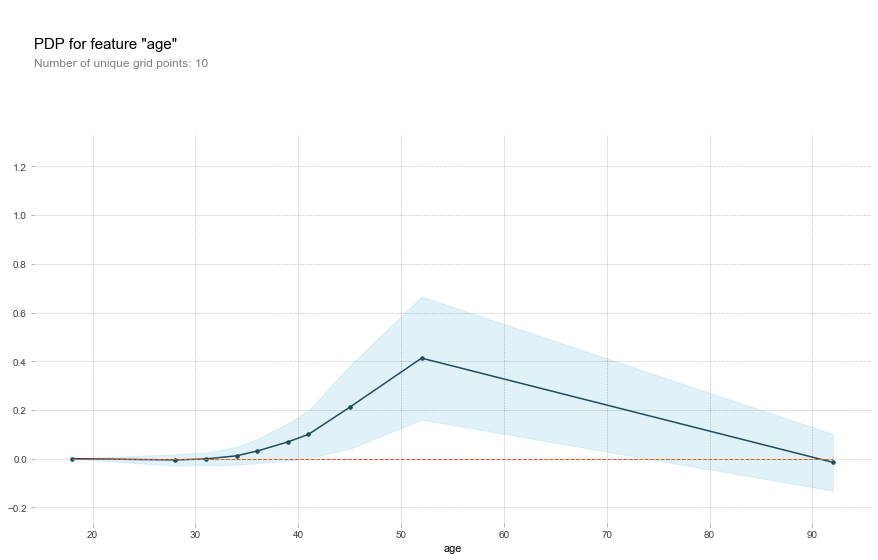

In [5]:
pdpf = pdp.pdp_isolate(
    model=xgb, dataset=X_train, model_features=X.columns, feature='age'
)
fig, axes = pdp.pdp_plot(pdpf, 'age')

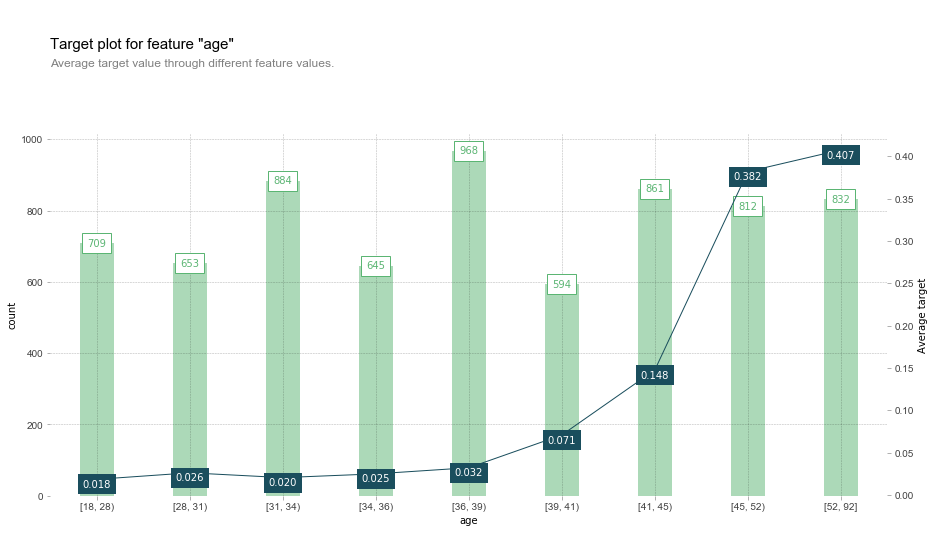

In [6]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_pdp, feature='age', feature_name='age', target='target'
)

pdp_salary = pdp.pdp_isolate(
    model=xgb, dataset=X_train, model_features=X.columns, feature='estimatedsalary'
)
fig, axes = pdp.pdp_plot(pdp_salary, 'Fare')

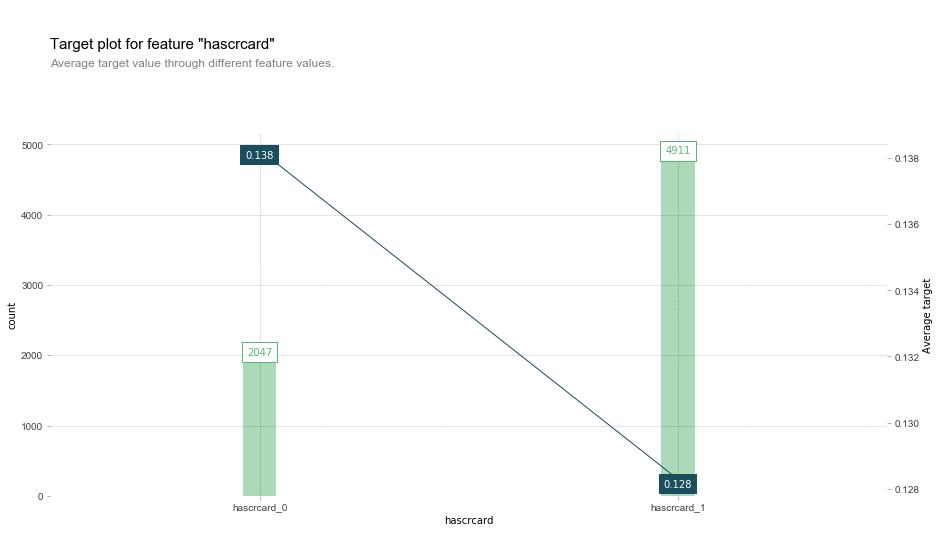

In [7]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_pdp, feature='hascrcard', feature_name='hascrcard', target='target'
)

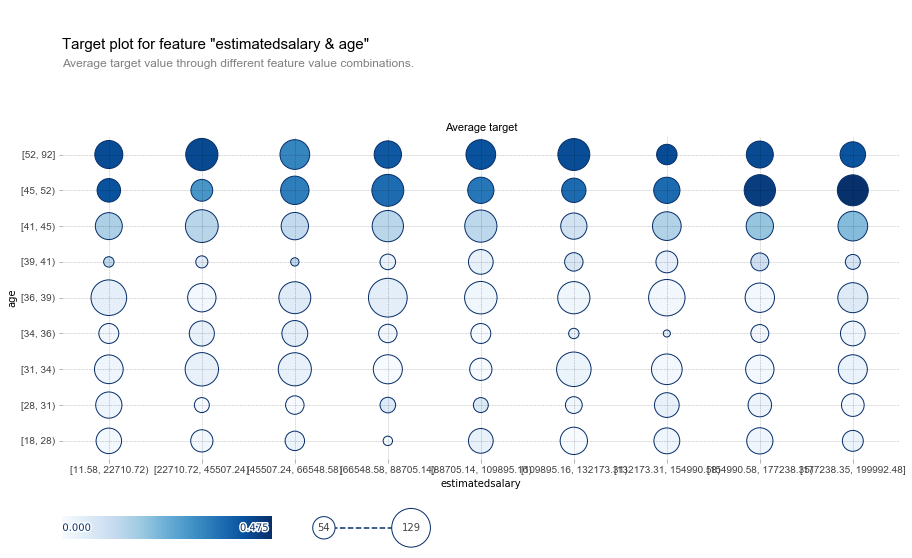

In [8]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=X_pdp, features=['estimatedsalary', 'age'], 
    feature_names=['estimatedsalary', 'age'], target='target'
)

## Critiques et limitations

Bien que les PDP soient visuellement facile à interpréter, ils souffrent néanmoins de plusieurs problèmes :

- Il est très difficile d'évaluer les interactions croisées entre les variables dès lors que l'on souhaite en étudier plus que $2$.
- L'hypothèse d'indépendance avec les autres variables (l'ensemble $J$) est potentiellement peu vérifiée.
- Si les effets marginaux individuels sont très hétérogènes, l'aggrégation faites par le PDP empêche de vérifier si la courbe obtenue est bien représentative de l'ensemble de l'échantillon. Pour cela, on affiche également les Individual Conditional Expectation (ICE) plots. 